In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# TQDM显示选项
TQDM = tqdm_notebook
# TQDM = tqdm

# 不显示警告
# import warnings
# warnings.filterwarnings("ignore")


# 指定GPU/CPU参数
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('DEVICE:', DEVICE)

DEVICE: cpu


In [2]:
## -------------------------- 数据集类 ------------------------------


class MyDataset(Dataset):
    '''加载数据集的类'''

    def __init__(self, root_dir, cls):
        '''初始化数据集,主要步骤如下:
        1.加载所有的csv表格'''

        self.df_l = []
        self.samples_all = 0  # 记录产生的sample time series总量
        self.samples_l = []  # 记录各个csv数据产生的sample time series长度
        for file in TQDM(os.listdir(root_dir), desc='加载%s数据' % cls):
            if not file.endswith('.csv'):  # 非csv数据跳过
                continue
            #df_this = pd.read_csv(os.path.join(
            #    root_dir, file)).set_index('Time')[FEAT_SELECT]
            df_this = pd.read_csv(os.path.join(
                root_dir, file), usecols=FEAT_SELECT)

            df_this = pd.DataFrame(SCALE.fit_transform(
                df_this), columns=df_this.columns)

            LEN = len(df_this)
            # 最后TROUBLE_LEN长度添加上标签1(其余是0),定义为列label
            label = np.concatenate([np.zeros(int(LEN - TROUBLE_LEN * 100)),
                                    np.ones(int(TROUBLE_LEN * 100))])
            df_this['label'] = label.astype(int)
            self.df_l.append(df_this)
            # 计算本csv数据能够产生的窗口数量
            window_num = LEN - WINDOW_LEN * 100 + 1
            self.samples_l.append(window_num)
            self.samples_all += window_num

    def __len__(self):
        return self.samples_all
    
    def save_to_file(self,filepath):
        all_data=[]
        all_label=[]
        for i in TQDM(range(self.samples_all),desc='数据保存中',total=self.samples_all):
            thisX,thisy=self[i]
            all_data.append(thisX.tolist());all_label.append(thisy.item())
        all_data=np.stack(all_data);all_label=np.array(all_label)
        print('数据输出到文件中...')
        np.savez(filepath,data=all_data,label=all_label)

    def __getitem__(self, idx):
        # 找出两个索引位置
        samples_cumsum = np.array(self.samples_l).cumsum()
        key1 = np.searchsorted(samples_cumsum, idx + 1)
        # 大于第一个cumsum 要减去前面的累加值，否则就是idx
        key2 = idx - samples_cumsum[key1 - 1] if key1 > 0 else idx

        # 通过key1找到对应的df
        target_df = self.df_l[key1]
        
        
        # 通过key2找到对应的value
        df_sample = target_df.iloc[key2: key2 + WINDOW_LEN * 100]

        # print(key1, key2, key2 + WINDOW_LEN * 100)

        X = df_sample.drop('label', axis=1).values
        y = df_sample['label'].values[-1]

        X = torch.Tensor(X)  # feat
        y = torch.tensor(y).long()  # label last

        return (X, y)  # shapeX= (3000,feat_num) shapey=(3000)



In [12]:
# -------------------------- 模型类 ------------------------------


class LSTMTagger(nn.Module):

    def __init__(self, input_dim, rnn_hidden, out_hidden, tagset_size, batch_size,
                 rnn_layer=1, out_activate='relu', flatten=False, rnn_type='lstm',
                 dropout_rate=0, bidirectional=False):
        '''参数解释
        @input_dim  rnn_hidden  out_hidden tagset_size 四个维度
        @batch的大小
        @rnn_layer rnn结构的层数
        @out_activate 输出前隐藏层激活函数
        @rnn_type rnn结构的类型
        @flatten: 是否选择flatten的方式
        @dropout_rate dropout的比例
        @bidirectional网络是否双向'''
        super(LSTMTagger, self).__init__()
        self.rnn_hidden = rnn_hidden
        self.rnn_layer = rnn_layer
        self.batch_size = batch_size
        self.flatten = flatten
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        self.num_direction = 2 if bidirectional else 1  # 双向情况下num_direction为2，单向为1

        # LSTM以word_embeddings作为输入, 输出维度为 hidden_dim 的隐藏状态值
        # batch_first If True, then the input and output tensors are provided
        # as (batch, seq, feature). Default: False
        if rnn_type == 'lstm':
            print('网络结构 --> LSTM')
            self.rnn = nn.LSTM(input_dim, rnn_hidden, rnn_layer, batch_first=True,
                               dropout=dropout_rate, bidirectional=bidirectional)
        elif rnn_type == 'gru':
            print('网络结构 --> GRU')
            self.rnn = nn.GRU(input_dim, rnn_hidden, rnn_layer, batch_first=True,
                              dropout=dropout_rate, bidirectional=bidirectional)
        elif rnn_type == 'rnn':
            print('网络结构 --> RNN')
            self.rnn = nn.RNN(input_dim, rnn_hidden, rnn_layer, batch_first=True,
                              dropout=dropout_rate, bidirectional=bidirectional)

        # LSTM层之后接一个线性层
        if flatten:
            self.rnn2hidden = nn.Linear(
                WINDOW_LEN * 100 * rnn_hidden * self.num_direction, out_hidden)
        else:
            self.rnn2hidden = nn.Linear(
                self.num_direction * rnn_hidden, out_hidden)
        # 线性层激活函数
        if out_activate == 'relu':
            self.out_activate = nn.ReLU()
        elif out_activate == 'tanh':
            self.out_activate = nn.Tanh()

        # 输出层将隐藏状态空间映射到标注空间
        self.hidden2tag = nn.Linear(out_hidden, tagset_size)

        self.hidden = self.init_hidden()

    def init_hidden(self):
        # 一开始并没有隐藏状态所以我们要先初始化一个,关于维度为什么这么设计请参考Pytoch相关文档
        # 各个维度的含义是 (num_layers * num_directions, batch, hidden_size)
        if self.rnn_type == 'lstm':
            h_n = torch.zeros(self.rnn_layer * self.num_direction,
                              self.batch_size, self.rnn_hidden).to(DEVICE)
            c_n = torch.zeros(self.rnn_layer * self.num_direction,
                              self.batch_size, self.rnn_hidden).to(DEVICE)
            return (h_n, c_n)
        elif self.rnn_type == 'gru':
            h_n = torch.zeros(self.rnn_layer * self.num_direction,
                              self.batch_size, self.rnn_hidden).to(DEVICE)
            return h_n

    def forward(self, embeds):
        rnn_out, self.hidden = self.rnn(embeds, self.hidden)

        rnn_out, hidden = self.rnn(embeds, self.hidden)

        if self.flatten:
            hidden_in = self.rnn2hidden(rnn_out.reshape(self.batch_size, -1))
        else:
            if self.bidirectional:
                last_f = rnn_out[:, -1, :self.rnn_hidden]  # 正向最后一个
                last_b = rnn_out[:, 0, self.rnn_hidden:]  # 反向最后一个
                last_out = torch.cat([last_f, last_b], axis=1)
            else:
                last_out = rnn_out[:, -1, :]

            hidden_in = self.rnn2hidden(last_out)

        hidden_out = self.out_activate(hidden_in)
        tag_scores = self.hidden2tag(hidden_out)  # 取最后一个时刻的标签值
        return tag_scores

In [13]:
# -------------------------- 模型训练主函数 ------------------------------
def train_model():
    best_model,best_auc=None,0 #保存最好的AUC和模型
    
    # 存储绘制图像的参数
    train_loss_l,train_acc_l,train_auc_l=[],[],[]
    test_acc_l,test_auc_l=[],[]
    
    print('=================== 模型训练/测试 ===================')
    for epoch in range(1,EPOCH+1):
        # -----------------epoch 训练----------------------
        train_loss, train_pred, train_true = 0.0, [], []

        for i, (X, y) in TQDM(enumerate(train_dataloader), desc='EPOCH-%d 训练' % epoch,
                              total=len(train_dataloader)):
        # for i, (X, y) in enumerate(train_dataloader):
            model.train()  # 打开train模式
            X, y = X.to(DEVICE), y.to(DEVICE)  # GPU/CPU
            # Pytorch会累加梯度.我们需要在训练每个实例前清空梯度
            model.zero_grad()
            # 需要清空 LSTM 的隐状态,将其从上个实例的历史中分离出来.
            model.hidden = model.init_hidden()
            # 前向传播.
            tag_scores = model(X)
            # import ipdb
            # ipdb.set_trace()
            _, preds = tag_scores.max(1)
            # 计算损失和梯度值, 通过调用 optimizer.step() 来更新梯度
            loss = loss_function(tag_scores, y)
            # backward
            loss.backward()
            # 防止梯度爆炸
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            # 优化器
            optimizer.step()
            # 累加指标
            train_loss += loss.item()
            train_pred.extend(preds.tolist())
            train_true.extend(y.tolist())

            
        loss = train_loss / len(train_dataset)        
        train_auc = roc_auc_score(train_true, train_pred)
        train_acc = accuracy_score(train_true, train_pred)
        
        
        print('Train epoch:%d,Loss:%f, AUC: %f, ACC=%f' %(epoch, loss, train_auc, train_acc))
        train_loss, train_pred, train_true = 0.0, [], []


        # -----------------epoch 测试----------------------
        model.eval()  # 打开eval模式
        test_pred, test_true = [], []
        with torch.no_grad():  # 不改变梯度
            for i, (X, y) in TQDM(enumerate(test_dataloader), desc='EPOCH-%d 测试' % epoch,
                                  total=len(test_dataloader)):
                X, y = X.to(DEVICE), y.to(DEVICE)  # GPU/CPU
                # 需要清空 LSTM 的隐状态,将其从上个实例的历史中分离出来.
                model.hidden = model.init_hidden()
                tag_scores = model(X)
                _, preds = tag_scores.max(1)
                test_pred.extend(preds.tolist())
                test_true.extend(y.tolist())
            test_auc = roc_auc_score(test_true, test_pred)
            test_acc = accuracy_score(test_true, test_pred)
            
            
            # auc更好时，保存更好的模型
            if test_auc>best_auc:
                best_auc=test_auc
                best_model=model

            # print(test_pred, test_true)
            print('Test epoch:%d, AUC: %f, ACC=%f' % (epoch, test_auc, test_acc))
        
        # 一个epoch结束，数据记录
        # 存储绘制图像的参数 
        train_loss_l.append(loss)
        train_acc_l.append(train_acc);test_acc_l.append(test_acc)
        train_auc_l.append(train_auc);test_auc_l.append(test_auc)
        
    # 训练全部完成，打印best_auc，返回best_model
    print('best Test AUC is:',best_auc)
    
    # 绘制图像
    df_loss=pd.DataFrame({'train_loss':train_loss_l})
    df_acc=pd.DataFrame({'train_acc':train_acc_l,'test_acc':test_acc_l})
    df_auc=pd.DataFrame({'train_auc':train_auc_l,'test_auc':test_auc_l})
    
    df_loss.plot(figsize=(10,10),title='Train_loss Figure')
    plt.show()
    df_acc.plot(figsize=(10,10),title='ACC Figure')
    plt.show()
    df_auc.plot(figsize=(10,10),title='AUC Figure')
    plt.show()
    
    
    # 导出每个epoch的数据
    with open('epoch绘图数据.csv',"w") as file:
        pd.DataFrame({'epoch':range(1,EPOCH+1),'train_loss':train_loss_l,
                      'train_acc':train_acc_l,'test_acc':test_acc_l,'train_auc':train_auc_l,
                      'test_auc':test_auc_l}).to_csv(file,index=None)
    
    
    return best_model

In [14]:
# -------------------------- 模型数据加载 ------------------------------
# 训练/测试 数据存储路径
TRAIN_DIR, TEST_DIR = './train', './test'
# 故障标签长度(s)
TROUBLE_LEN = 0.5
# WINDOW时间长度(s)
WINDOW_LEN = 59
# 选择使用的特征列表
FEAT_SELECT = ['[8:2]', '[6:17]', '[1:7]', '[1:5]',
               '[1:20]', '[1:0]', '[1:1]', '[8:4]', '[1:133]']
#归一化选项
SCALE = StandardScaler() 
# SCALE = MinMaxScaler()



print('=================== 数据集构建 ===================')
train_dataset = MyDataset(root_dir=TRAIN_DIR, cls='训练')
test_dataset = MyDataset(root_dir=TEST_DIR, cls='测试')

# ---------- 数据加载器DataLoader ----------
BATCH_SIZE = 10  # batch数据的大小
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_datalen, test_datalen = len(train_dataset), len(test_dataset)

=================== 数据集构建 ===================


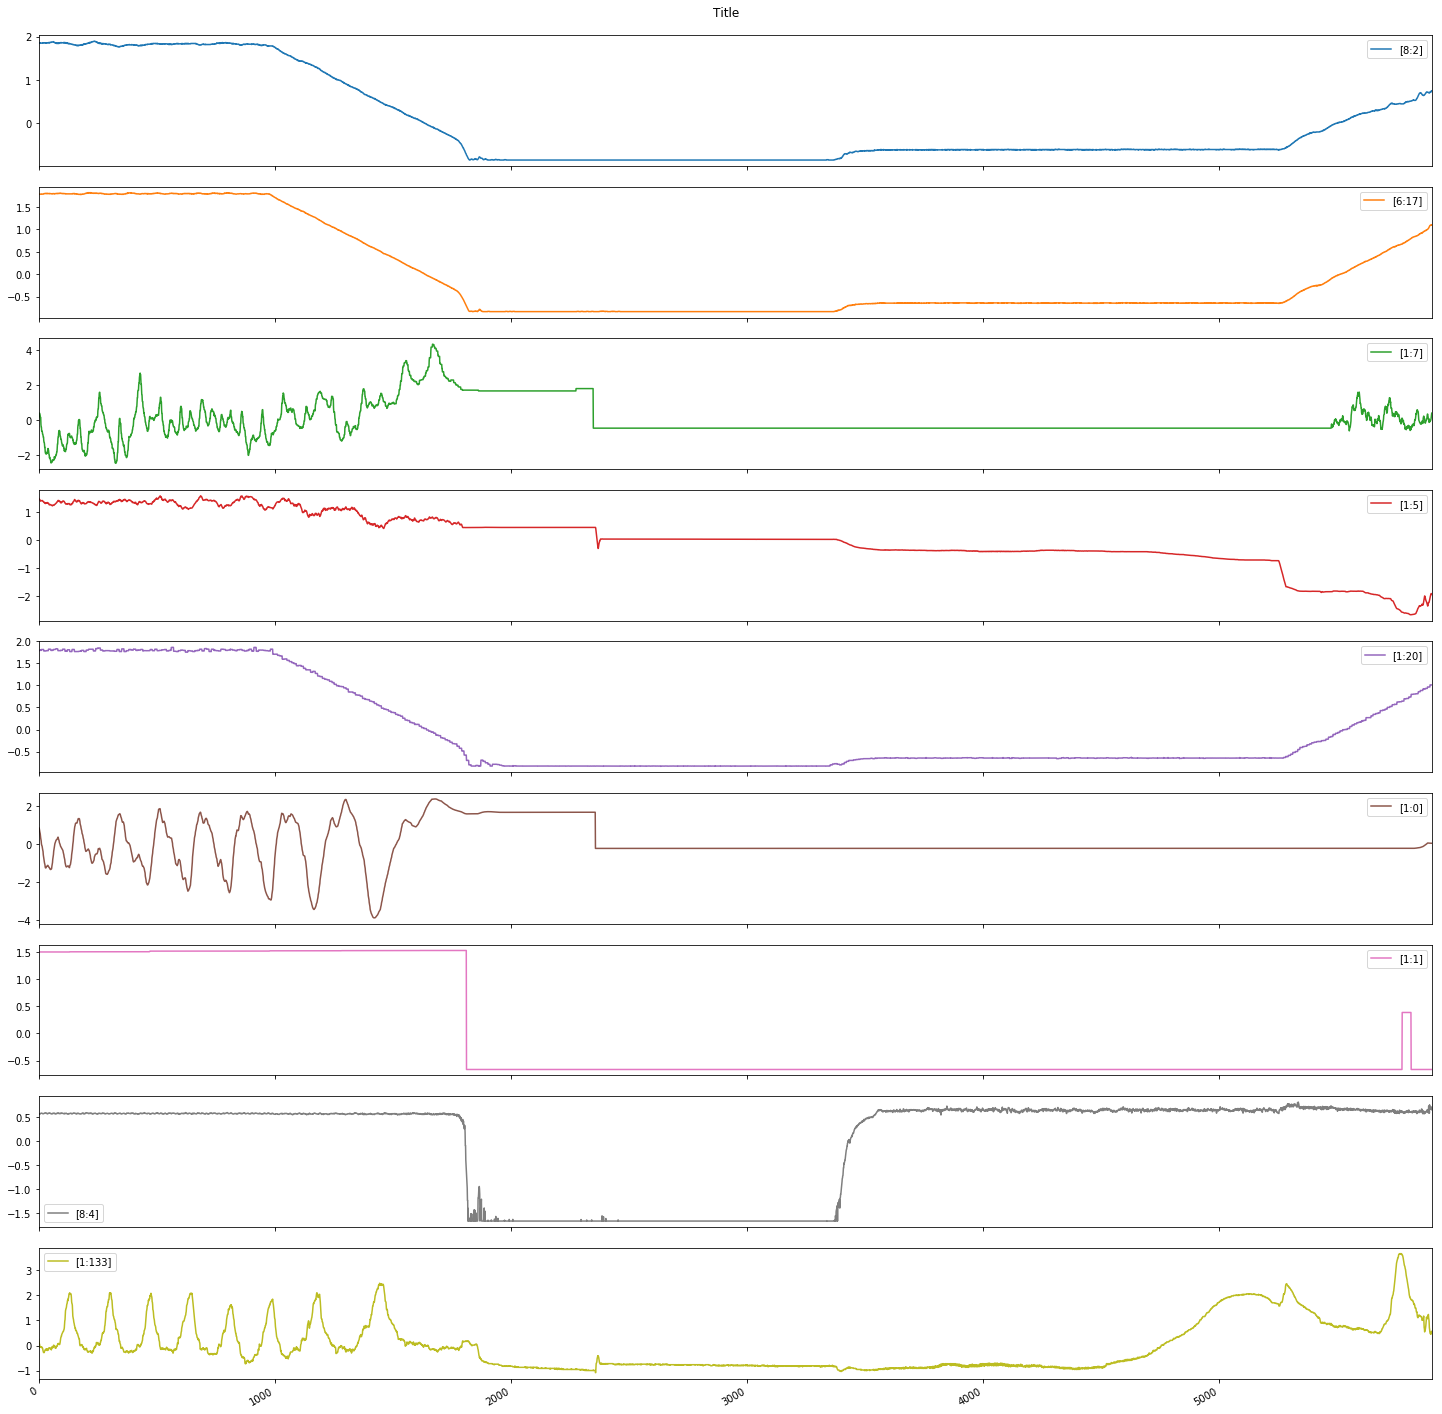

In [36]:
# 可视化一个window数据的过程

#构造一个window的DataFrame df_window
data_window=train_dataset[0] #索引0可更换
X,y=data_window
df_window=pd.DataFrame(X.tolist(),columns=FEAT_SELECT)
#保存数据到csv文件
df_window.to_csv('./window_data.csv') 
#绘图
df_window.plot(figsize=(20,20),subplots=True,title='Title')
plt.tight_layout(rect=[0,0,1,0.97])


In [37]:
# -------------------------- 训练可调参数 ------------------------------
EMBEDDING_DIM = len(FEAT_SELECT)
RNN_HIDDEN = 10  # RNN隐含层维度
TAGSET_SIZE = 2  # 目标维度
RNN_LAYER = 2  # RNN结构的层数
EPOCH = 1  # 训练EPOCH
OUTPUT_HIDDEN = 20  # 输出层之前的隐含层维度
OUTPUT_ACTIVATE = 'relu'  # 输出层之前的隐含层激活函数 relu/tanh
FLATTEN = False  # 是否采用flatten训练方式 True/False
RNN_TYPE = 'RNN'.lower()  # 模型类型 gru/lstm/rnn
DROPOUT_RATE = 0.1  # DROPOUT的比例
BI_DIRECT = False  # 网络是否采用双向模式


# 模型初始化
model = LSTMTagger(EMBEDDING_DIM, RNN_HIDDEN, OUTPUT_HIDDEN, TAGSET_SIZE, BATCH_SIZE,
                   rnn_layer=RNN_LAYER, out_activate=OUTPUT_ACTIVATE, flatten=FLATTEN,
                   rnn_type=RNN_TYPE, dropout_rate=DROPOUT_RATE, bidirectional=BI_DIRECT)
model.to(DEVICE)  # GPU/CPU

# 损失函数
loss_function = nn.CrossEntropyLoss()

# 参数优化方案
optimizer = optim.Adam(model.parameters(), lr=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.1)


网络结构 --> RNN


In [1]:
best_model=train_model()
# 保存模型的方法（保存成二进制文件）
torch.save(best_model,open('best_model.pkl','wb'))
# 再次读取模型的方法
# model_reload=torch.load(open('best_model.pkl','rb'))

In [55]:
best_model

LSTMTagger(
  (rnn): RNN(9, 10, num_layers=2, batch_first=True, dropout=0.1)
  (rnn2hidden): Linear(in_features=10, out_features=20, bias=True)
  (out_activate): ReLU()
  (hidden2tag): Linear(in_features=20, out_features=2, bias=True)
)